In [5]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm


class PairTradingBacktester:

    # METHOD 1 - Initialises key variables and settings for the backtest
    def __init__(self, tickers, start_date, end_date, window=20,
                 entry_threshold=None, exit_threshold=None, cost_per_trade=0.001, max_leverage=2, kelly_fraction=0.5):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.window = window  # Rolling window size for indicator calculations
        self.entry_threshold = entry_threshold  # Z-score threshold to enter a trade
        self.exit_threshold = exit_threshold  # Z-score threshold to exit a trade
        self.cost_per_trade = cost_per_trade  # Transaction cost per unit traded
        self.max_leverage = max_leverage  # Maximum allowable leverage
        self.kelly_fraction = kelly_fraction  # Fraction of Kelly criterion to use
        self.data = None
        self.train = None
        self.test = None

    # METHOD 2 - Retrieves historical price data from Yahoo Finance
    def load_data(self):
        prices = yf.download(self.tickers, start=self.start_date, end=self.end_date)["Close"]
        self.data = prices.dropna()  # Removes rows with missing values

    # METHOD 3 - Splits data into training and test subsets based on date
    def train_test_split(self, split_date):
        self.train = self.data[:split_date].copy()
        self.test = self.data[split_date:].copy()

    # METHOD 4 - Tests if the pair of assets is cointegrated
    def check_cointegration(self):
        score, pvalue, _ = coint(self.train[self.tickers[0]], self.train[self.tickers[1]])
        print(f"Cointegration test p-value: {pvalue:.4f}")

        RED = "\033[91m"
        GREEN = "\033[92m"
        RESET = "\033[0m"

        if pvalue < 0.05:
            print(f"{GREEN}Pair is cointegrated. Proceeding.{RESET}")
        else:
            print(f"{RED}WARNING: Pair is not cointegrated. Results may be unreliable.{RESET}")

    # METHOD 5 - Optimises entry and exit thresholds based on Sharpe ratio
    def optimize_thresholds(self):
        best_sharpe = -np.inf
        best_params = None

        # Grid search over a range of thresholds
        for entry in np.arange(1.0, 2.5, 0.1):
            for exit in np.arange(0.2, 1.0, 0.1):
                df = self.train.copy()
                self.entry_threshold = entry
                self.exit_threshold = exit

                hedge_ratio = self.compute_hedge_ratio(df)
                df = self.compute_indicators(df, hedge_ratio)
                df = self.generate_signals(df, hedge_ratio)
                df = self.compute_returns(df)

                returns = df["strategy_returns"]
                sharpe = returns.mean() / returns.std() * np.sqrt(252)

                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_params = (entry, exit)

        self.entry_threshold, self.exit_threshold = best_params
        self.best_sharpe = best_sharpe
        print(f"Optimised thresholds: entry = {self.entry_threshold:.2f}, exit = {self.exit_threshold:.2f}")

    # METHOD 6 - Computes the hedge ratio using linear regression
    def compute_hedge_ratio(self, df):
        asset_1 = df[self.tickers[0]]
        asset_2 = df[self.tickers[1]]
        X = sm.add_constant(asset_2)
        model = sm.OLS(asset_1, X).fit()
        hedge_ratio = model.params[self.tickers[1]]
        return hedge_ratio

    # METHOD 7 - Calculates rolling mean, standard deviation, and z-score
    def compute_indicators(self, df, hedge_ratio):
        df["adjusted_ratio"] = df[self.tickers[0]] / (df[self.tickers[1]] * hedge_ratio)
        df["mean"] = df["adjusted_ratio"].rolling(window=self.window).mean().shift(1)
        df["std"] = df["adjusted_ratio"].rolling(window=self.window).std().shift(1)
        df["z_score"] = (df["adjusted_ratio"] - df["mean"]) / df["std"]
        df.dropna(inplace=True)
        return df

    # METHOD 8 - Generates trading signals based on z-score and Kelly-adjusted leverage
    def generate_signals(self, df, hedge_ratio):
        df["position_one"] = 0.0
        df["position_two"] = 0.0
        in_position = 0

        for i in range(len(df)):
            z = df["z_score"].iloc[i]

            # Calculate Kelly leverage based on recent z-scores
            if i >= self.window:
                recent_returns = df["z_score"].iloc[i - self.window:i]
                kelly = self.calculate_kelly(recent_returns)
            else:
                kelly = 0

            # Adjust leverage using Kelly fraction and maximum cap
            dynamic_leverage = min(self.kelly_fraction * kelly, self.max_leverage)
            dynamic_leverage = max(0, dynamic_leverage)

            # Signal logic
            if in_position == 0:
                if z > self.entry_threshold:
                    in_position = -dynamic_leverage / (1 + abs(hedge_ratio))  # Short spread
                elif z < -self.entry_threshold:
                    in_position = dynamic_leverage / (1 + abs(hedge_ratio))  # Long spread
            elif in_position > 0 and z > -self.exit_threshold:
                in_position = 0  # Exit long
            elif in_position < 0 and z < self.exit_threshold:
                in_position = 0  # Exit short

            df.at[df.index[i], "position_one"] = in_position
            df.at[df.index[i], "position_two"] = -in_position * hedge_ratio

        # Calculate dynamic leverage for reference
        df["dynamic_leverage"] = abs(df["position_one"]) + abs(df["position_two"])

        return df

    # METHOD 9 - Calculates Kelly fraction based on recent z-score volatility
    def calculate_kelly(self, z_scores_window):
        mu = z_scores_window.mean()
        sigma = z_scores_window.std()
        if sigma > 0:
            return mu / (sigma ** 2)
        else:
            return 0

    # METHOD 10 - Calculates strategy returns, transaction costs, and cumulative performance
    def compute_returns(self, df):
        df["returns_one"] = df[self.tickers[0]].pct_change()
        df["returns_two"] = df[self.tickers[1]].pct_change()

        df["position_change"] = df["position_one"].diff().abs() + df["position_two"].diff().abs()
        df["transaction_costs"] = df["position_change"] * self.cost_per_trade

        df["strategy_returns"] = (
            df["position_one"].shift(1) * df["returns_one"] +
            df["position_two"].shift(1) * df["returns_two"]
        ) - df["transaction_costs"]

        df["cumulative_returns"] = (1 + df["strategy_returns"]).cumprod()
        df["gross_exposure"] = abs(df["position_one"]) + abs(df["position_two"])

        return df

    # METHOD 11 - Evaluates strategy performance using Sharpe ratio and drawdown
    def evaluate_performance(self, df, label="Set"):
        risk_free_rate = 0.03 / 252
        sharpe = (df["strategy_returns"].mean() - risk_free_rate) / df["strategy_returns"].std() * np.sqrt(252)
        drawdown = (df["cumulative_returns"].cummax() - df["cumulative_returns"]).max()
        total_return = df["cumulative_returns"].iloc[-1] - 1
        print(f"{label} Performance:")
        print(f"  Sharpe Ratio: {sharpe:.2f}")
        print(f"  Max Drawdown: {drawdown:.2%}")
        print(f"  Total Return: {total_return:.2%}")

    # METHOD 12 - Plots cumulative returns for training and test sets
    def plot(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.train["cumulative_returns"], label="Training")
        plt.plot(self.test["cumulative_returns"], label="Test")
        plt.title(f"Pair Trading Strategy: {self.tickers[0]} / {self.tickers[1]}")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.grid(True)
        plt.show()

    # METHOD 13 - Executes the full backtesting pipeline
    def run(self, split_date):
        self.load_data()
        self.train_test_split(split_date)
        self.check_cointegration()

        if self.entry_threshold is None or self.exit_threshold is None:
            self.optimize_thresholds()

        # Run full pipeline for training data
        hedge_ratio_train = self.compute_hedge_ratio(self.train)
        self.train = self.compute_indicators(self.train, hedge_ratio_train)
        self.train = self.generate_signals(self.train, hedge_ratio_train)
        self.train = self.compute_returns(self.train)

        # Run full pipeline for test data
        hedge_ratio_test = self.compute_hedge_ratio(self.test)
        self.test = self.compute_indicators(self.test, hedge_ratio_test)
        self.test = self.generate_signals(self.test, hedge_ratio_test)
        self.test = self.compute_returns(self.test)

        self.evaluate_performance(self.train, "Training")
        self.evaluate_performance(self.test, "Test")
        self.plot()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Cointegration test p-value: 0.0463
Pair is cointegrated. Proceeding.
Optimised thresholds: entry = 1.50, exit = 0.90
Training Performance:
  Sharpe Ratio: 0.61
  Max Drawdown: 17.14%
  Total Return: 95.64%
Test Performance:
  Sharpe Ratio: 0.78
  Max Drawdown: 8.28%
  Total Return: 30.70%


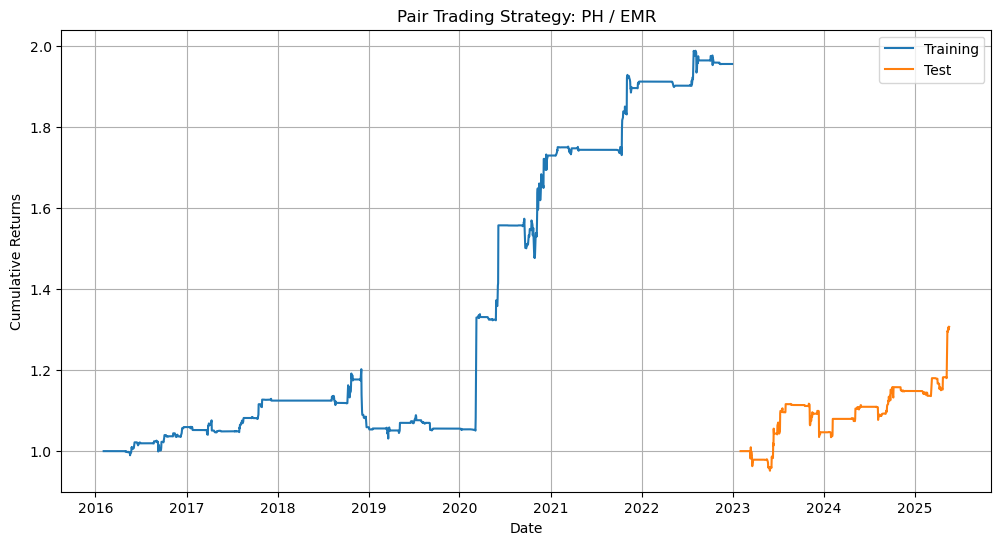

In [7]:
# Instantiate the backtester with chosen parameters
bt = PairTradingBacktester(
    tickers = ["PH", "EMR"],           # Tickers for the asset pair to be tested
    start_date = "2016-01-01",         # Start date for historical data
    end_date = None,                   # End date is None, so it defaults to the most recent available data
    window = 20,                       # Rolling window size for z-score and moving average calculations
    cost_per_trade = 0.001,            # Assumed transaction cost per trade (0.1%)
    max_leverage = 2.0,                # Maximum leverage allowed for positions
    kelly_fraction = 0.75              # Fraction of Kelly criterion to apply for position sizing
)

# Run the full backtest with a training/testing split on the specified date
bt.run(split_date = "2023-01-01")     # Data before 2023-01-01 is used for training; after is for testing
